<a href="https://colab.research.google.com/github/RiseAboveAll/RSNA_Pneumonia/blob/master/VGG_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 84kB/s 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import pydicom

import csv
import random

from glob import glob #The glob module finds all the pathnames matching a specified pattern according to the rules
import os

import tensorflow as tf
#from tensorflow import keras

from skimage import measure
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split as tts

import math
import cv2

#from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import graphviz
import pydotplus
from keras.utils import plot_model

Using TensorFlow backend.


In [94]:
from tensorflow.keras.preprocessing.image import array_to_img

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
Path='/content/drive/My Drive/'
#Image_Path='/content/drive/My Drive/Capstone/train_images/'
os.chdir(Path)

In [8]:
train_X=pd.read_csv('/content/drive/My Drive/Train_X.csv')
val_X=pd.read_csv('/content/drive/My Drive/Val_X.csv')

In [9]:

IMAGE_SIZE = 224 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 15 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


In [139]:
#msk= np.zeros(img.shape)
class DataSequence(tf.keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],4))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,_=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            #self.coords[index,4]=Target
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            #img = Image.open(f) # Read image
            img = pydicom.dcmread(f).pixel_array
            img = np.expand_dims(img, -1)
            img=array_to_img(img)
            img=img.resize((IMAGE_SIZE, IMAGE_SIZE))
            #img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
            img = img.convert('RGB')
            

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords
    

In [140]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        smooth = tf.ones(tf.shape(intersections))
        #tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
        iou = tf.reduce_mean((intersections+smooth) / (unions - intersections + smooth ))
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

In [141]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

In [143]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred,axis=1)
    union = tf.reduce_sum(y_true,axis=1) + tf.reduce_sum(y_pred,axis=1)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


In [173]:
def create_model(trainable=True):

  model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
  for layer in model.layers:
    layer.trainable=trainable
  layer1_br = model.layers[-5].output
  layer2_br= Conv2D(512,(3,3),padding='same',activation='relu')(layer1_br)#Add 2nd FC layer to it 
  layer3=Conv2D(512,(1,1))(layer2_br)
  layer4=Conv2D(128,(1,1))(layer3)
  layer4=Conv2D(256,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
  layer5=Conv2D(64,(1,1))(layer4)
  layer5=Conv2D(128,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
  layer6=tf.keras.layers.AveragePooling2D((3,3))(layer5)
  layer7=Conv2D(4,(1,1))(layer6)#Add 5th FC layer to it
  R_layer= Reshape((4,))(layer7)

 

  return tf.keras.Model(inputs=model.input, outputs=R_layer)




In [174]:
model=create_model(False)

In [175]:
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [176]:
#optimizer=keras.optimizers.SGD(learning_rate=.01,nesterov=True,momentum=.9)
model.compile(loss=iou_bce_loss, optimizer='adam', metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = EPOCHS
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,learning_rate],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/15
328/662 [=============>................] - ETA: 1:26:28 - loss: 7.5270 - mean_iou: -1.8936

KeyboardInterrupt: ignored

In [98]:
train_X.head()

,Path,xmin,xmax,ymin,ymax,Target
0,/content/drive/My Drive/Capstone/train_images/...,0.0,0.0,0.0,0.0,0
1,/content/drive/My Drive/Capstone/train_images/...,0.0,0.0,0.0,0.0,0
2,/content/drive/My Drive/Capstone/train_images/...,0.0,0.0,0.0,0.0,0
3,/content/drive/My Drive/Capstone/train_images/...,330.0,481.0,292.0,516.0,1
4,/content/drive/My Drive/Capstone/train_images/...,300.0,454.0,420.0,572.0,1


In [135]:
img = pydicom.dcmread(train_X.Path[0]).pixel_array
#img = np.expand_dims(img, -1)
img=array_to_img(img)
img = img.convert('RGB')

img=img.resize((IMAGE_SIZE, IMAGE_SIZE))
#img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')


ValueError: ignored

In [132]:
i=np.asarray(img)

In [133]:
i.shape

(224, 224, 3)

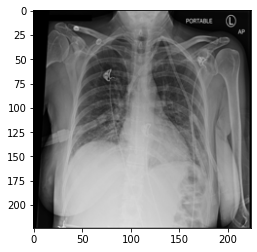

In [134]:
plt.imshow(i)

In [107]:
img=preprocess_input(np.array(img, dtype=np.float32))

In [108]:
img.shape

(224, 224, 3)

In [22]:
model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
output=model.layers[-5].output
vgg_model=tf.keras.Model(model.input,output)

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
vgg_model.trainable=False
for layer in vgg_model.layers:
  layer.trainable=False
layers=[(layer,layer.name,layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers,columns=['Layer Type','Laye_Name','Trainable'])

,Layer Type,Laye_Name,Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_4,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [49]:
for layer in model.layers[:19]:
  print(layer.name)

input_17
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [47]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     